In [1]:
import seaborn as sns
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
import pandas as pd
from os.path import exists, join
from io import StringIO  

In [2]:
ALGORITHMS = {
    'structural': 'Structural',
    'structural-variant': 'Splitted Structural',
    'sed': 'Bounded SED LB',
    'lblint': 'Label Intersection'
}

datasets = ('bolzano', 'dblp', 'ptb', 'python', 'sentiment', 'swissprot', 'treefam')

In [3]:
ALGORITHMS_ENUM_NAMES = {
    'structural': 'Structural',
    'structural-variant': 'StructuralVariant',
    'sed': 'Sed',
    'lblint': 'Lblint'
}

In [4]:
BASEPATH = 'resources/results/'
def load_dataset(dataset: str, threshold: int):
    algorithm_times = dict()
    for alg in ALGORITHMS.keys():
        join_times_path = join(BASEPATH, ds, str(threshold), f'{dataset}-{ALGORITHMS_ENUM_NAMES[alg]}-times-us.txt')
        if not exists(join_times_path):
            print(alg, 'is not computed for', dataset, f'{join_times_path} skipping')
            continue
        df = pd.read_csv(join_times_path, names=["time"])
        
        candidate_eval_times_path = join(BASEPATH, ds, str(threshold), f'{dataset}-{ALGORITHMS_ENUM_NAMES[alg]}-candidate-times-ns.txt')
        if not exists(candidate_eval_times_path):
            print(alg, 'is not computed for', dataset, f'{candidate_eval_times_path} skipping')
            continue
        lb_df = pd.read_csv(candidate_eval_times_path, names=["candidate_lb_time"])
        
        with open(join(BASEPATH, dataset, str(threshold), f'{dataset}-{alg}-precision.txt')) as f:
            selectivity_line = f.readline()
            rest = f.read()

        sel = selectivity_line.split(':')[1]
        sel = float(sel.rstrip('%\n'))
        print(sel)
        seldf = pd.DataFrame.from_dict({'selectivity': [sel] })
        precision = pd.read_csv(StringIO(rest), delimiter=';')
        algorithm_times[alg] = [df, precision, seldf, lb_df]
    return algorithm_times

In [5]:
# tested_values= [('swissprot', 20), ('bolzano', 20), ('python', 30), ('sentiment', 10), ('ptb', 10), ('treefam', 15), ('DBLP', 6)]
tested_values= [('bolzano', 20), ('sentiment', 10), ('ptb', 10), ('treefam', 15), ('python', 30)]

In [6]:
selectivities = [('swissprot', 0.0001851, 20), ('bolzano', 47.097, 20), ('python', 11.096, 30), ('sentiment', 0.840, 10), ('ptb', 0.0257827, 10), ('treefam', 13.99, 15), ('DBLP', 0, 6)]
pd.DataFrame.from_records(selectivities, columns=['Dataset', 'Mean query selectivity %', 'Threshold'])

,Dataset,Mean query selectivity %,Threshold
0,swissprot,0.000185,20
1,bolzano,47.097000,20
2,python,11.096000,30
3,sentiment,0.840000,10
4,ptb,0.025783,10
5,treefam,13.990000,15
6,DBLP,0.000000,6


In [7]:
dataframes = dict()
for ds, t in tested_values:
    dataframes[ds] = load_dataset(ds, t)

5.1908
5.0654
4.2137
5.9676
0.5142
0.461
0.3421
0.5916
0.0166
0.0158
0.0123
0.0195
0.0123
0.0123
0.0123
0.0126
0.5111
0.5067
0.4375
0.5618


In [141]:
def load_verification_times(dataset: str, threshold: int):
    percent_df, absolute_df, lb_df = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    empty = True
    for lb_method in ALGORITHMS.keys():
        # print(lb_method)
        apted_times = join(BASEPATH, dataset, str(threshold), f'{lb_method}-apted-verification-times-ns.csv')
        topdiff_times = join(BASEPATH, dataset, str(threshold), f'{lb_method}-topdiff-verification-times-ns.csv')
    
        apted_df = pd.read_csv(apted_times, skiprows=2, names=["apted-verification-nanos"])
        topdiff_df = pd.read_csv(topdiff_times, skiprows=2, names=["topdiff-verification-nanos"])
        df = apted_df.join(topdiff_df).join(dataframes[dataset][lb_method][3])
        df['total-apted'] = df['candidate_lb_time'] + df['apted-verification-nanos']
        df['total-topdiff'] = df['candidate_lb_time'] + df['topdiff-verification-nanos']
    
        df['apted-perc'] = 100 * (df['apted-verification-nanos'] /  df['total-apted'])
        df['topdiff-perc'] =  100 * (df['topdiff-verification-nanos'] /  df['total-topdiff'])
        df['lb_method'] = lb_method
        
        v_vars=['apted-perc', 'topdiff-perc']
        
        melted_percent = df.melt(
            value_vars=v_vars, id_vars=['lb_method'], var_name='verification-method', value_name='percent'
        )
        
        melted_absolute = df.melt(
            value_vars=['apted-verification-nanos', 'topdiff-verification-nanos'], id_vars=['lb_method'], var_name='verification-method', value_name='nanos'
        )

        melted_lb = df.melt(value_vars=['candidate_lb_time'], id_vars=['lb_method'], value_name='lb_time')
        
        if empty:
            percent_df = melted_percent
            absolute_df = melted_absolute
            lb_df = melted_lb
            empty = False
        else:
            # full_df = full_df.join(df.drop(columns=['apted-verification-nanos', 'topdiff-verification-nanos', 'candidate_lb_time']))
            # full_df = full_df.join(df.drop(columns=['apted-verification-nanos', 'topdiff-verification-nanos', 'candidate_lb_time']))
            percent_df = pd.concat([percent_df, melted_percent])
            absolute_df = pd.concat([absolute_df, melted_absolute])
            lb_df = pd.concat([lb_df, melted_lb])
        # df['lb-apted-perc'] = 100 - df['apted-perc']
        # df['lb-topdiff-perc'] =  100 - df['topdiff-perc'] 
    
    return percent_df, absolute_df, lb_df
    ...

In [142]:
melted_percent, melted_absolute, lb_df = load_verification_times('bolzano', 20)

# Verification time (TED time) % of complete LB + verification time

The lower the verification time %, the faster the LB method was in comparison to verification by using
either exact TED (APTED) or using bounded-TED (topdiff)

Loading  bolzano , t = 20 0
Loading  sentiment , t = 10 1
Loading  ptb , t = 10 2
Loading  treefam , t = 15 3
Loading  python , t = 30 4


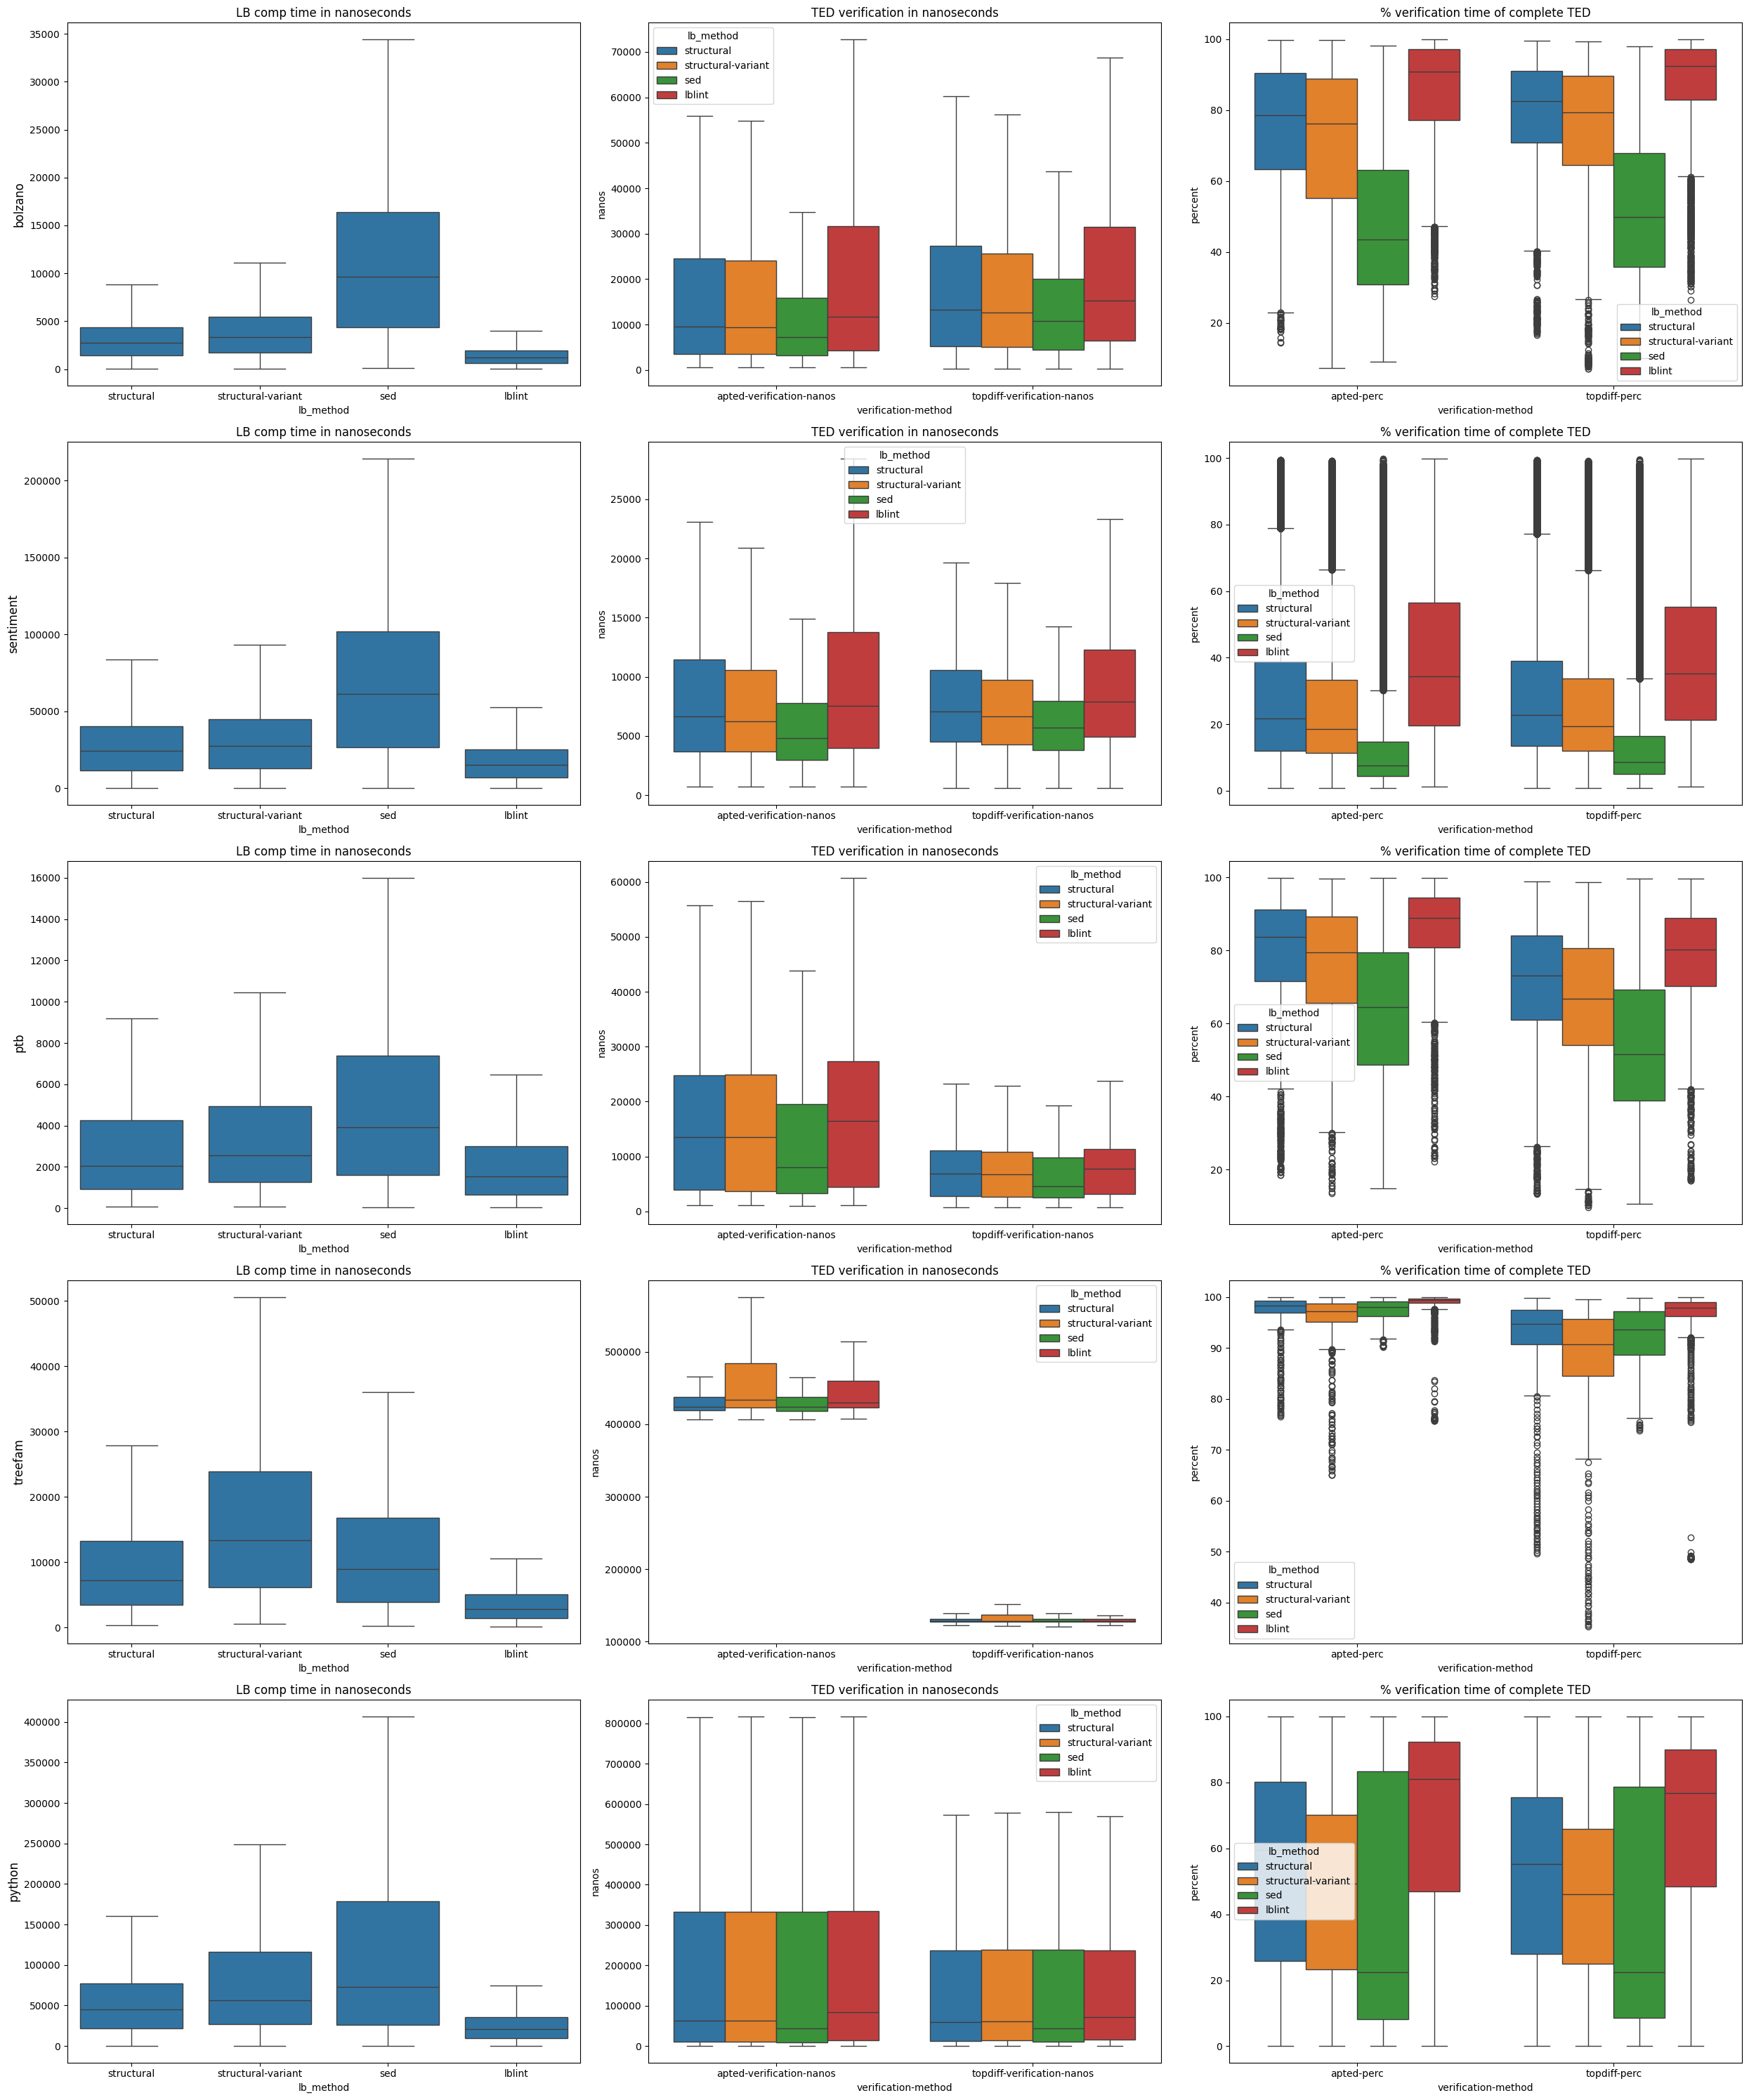

In [146]:
len_tested = len(tested_values)
fig, axes = plt.subplots(len_tested, 3, figsize=(25, 30))

for i, (ds, t) in enumerate(tested_values):
    print('Loading ', ds, ', t =', t, i)
    melted_percent, melted_absolute, lb_df = load_verification_times(ds, t)
    # fig.suptitle('Bolzano')
    sns.boxplot(data=lb_df, x='lb_method', y='lb_time', showfliers = False, ax=axes[i, 0])
    axes[i, 0].set_title('LB comp time in nanoseconds')
    sns.boxplot(data=melted_absolute, x='verification-method', hue='lb_method', y='nanos', showfliers = False, ax=axes[i, 1])
    axes[i, 1].set_title('TED verification in nanoseconds')
    sns.boxplot(data=melted_percent, x='verification-method', hue='lb_method', y='percent', ax=axes[i, 2])
    axes[i, 2].set_title('% verification time of complete TED')

for ax, (ds, _) in zip(axes[:, 0], tested_values):
    ax.set_ylabel(ds, size='large')

plt.tight_layout()
plt.show()

<Axes: xlabel='candidate_lb_time', ylabel='topdiff-verification-nanos'>

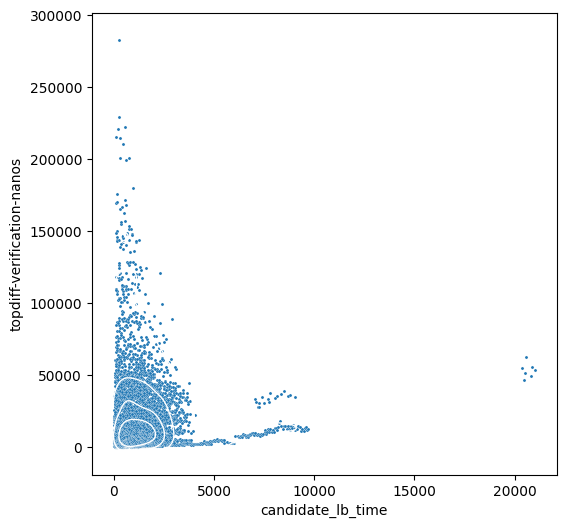

In [11]:
# sns.scatterplot(data=bolzano_lblint, x="candidate_lb_time", y="topdiff-verification-nanos")

# Draw a combo histogram and scatterplot with density contours
f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x=bolzano_lblint['candidate_lb_time'], y=bolzano_lblint['topdiff-verification-nanos'], s=5)
# sns.histplot(x=bolzano_lblint['candidate_lb_time'], y=bolzano_lblint['topdiff-verification-nanos'], bins=50, pthresh=.1, cmap="mako")
sns.kdeplot(x=bolzano_lblint['candidate_lb_time'], y=bolzano_lblint['topdiff-verification-nanos'], levels=5, color="w", linewidths=1)

In [28]:
dataframes['bolzano']['lblint'][3]

,candidate_lb_time
0,260
1,451
2,551
3,621
4,751
...,...
4487,471
4488,291
4489,220
4490,561


Printing  swissprot
Printing  bolzano
Printing  python
Printing  sentiment
Printing  ptb
Printing  treefam
Printing  DBLP


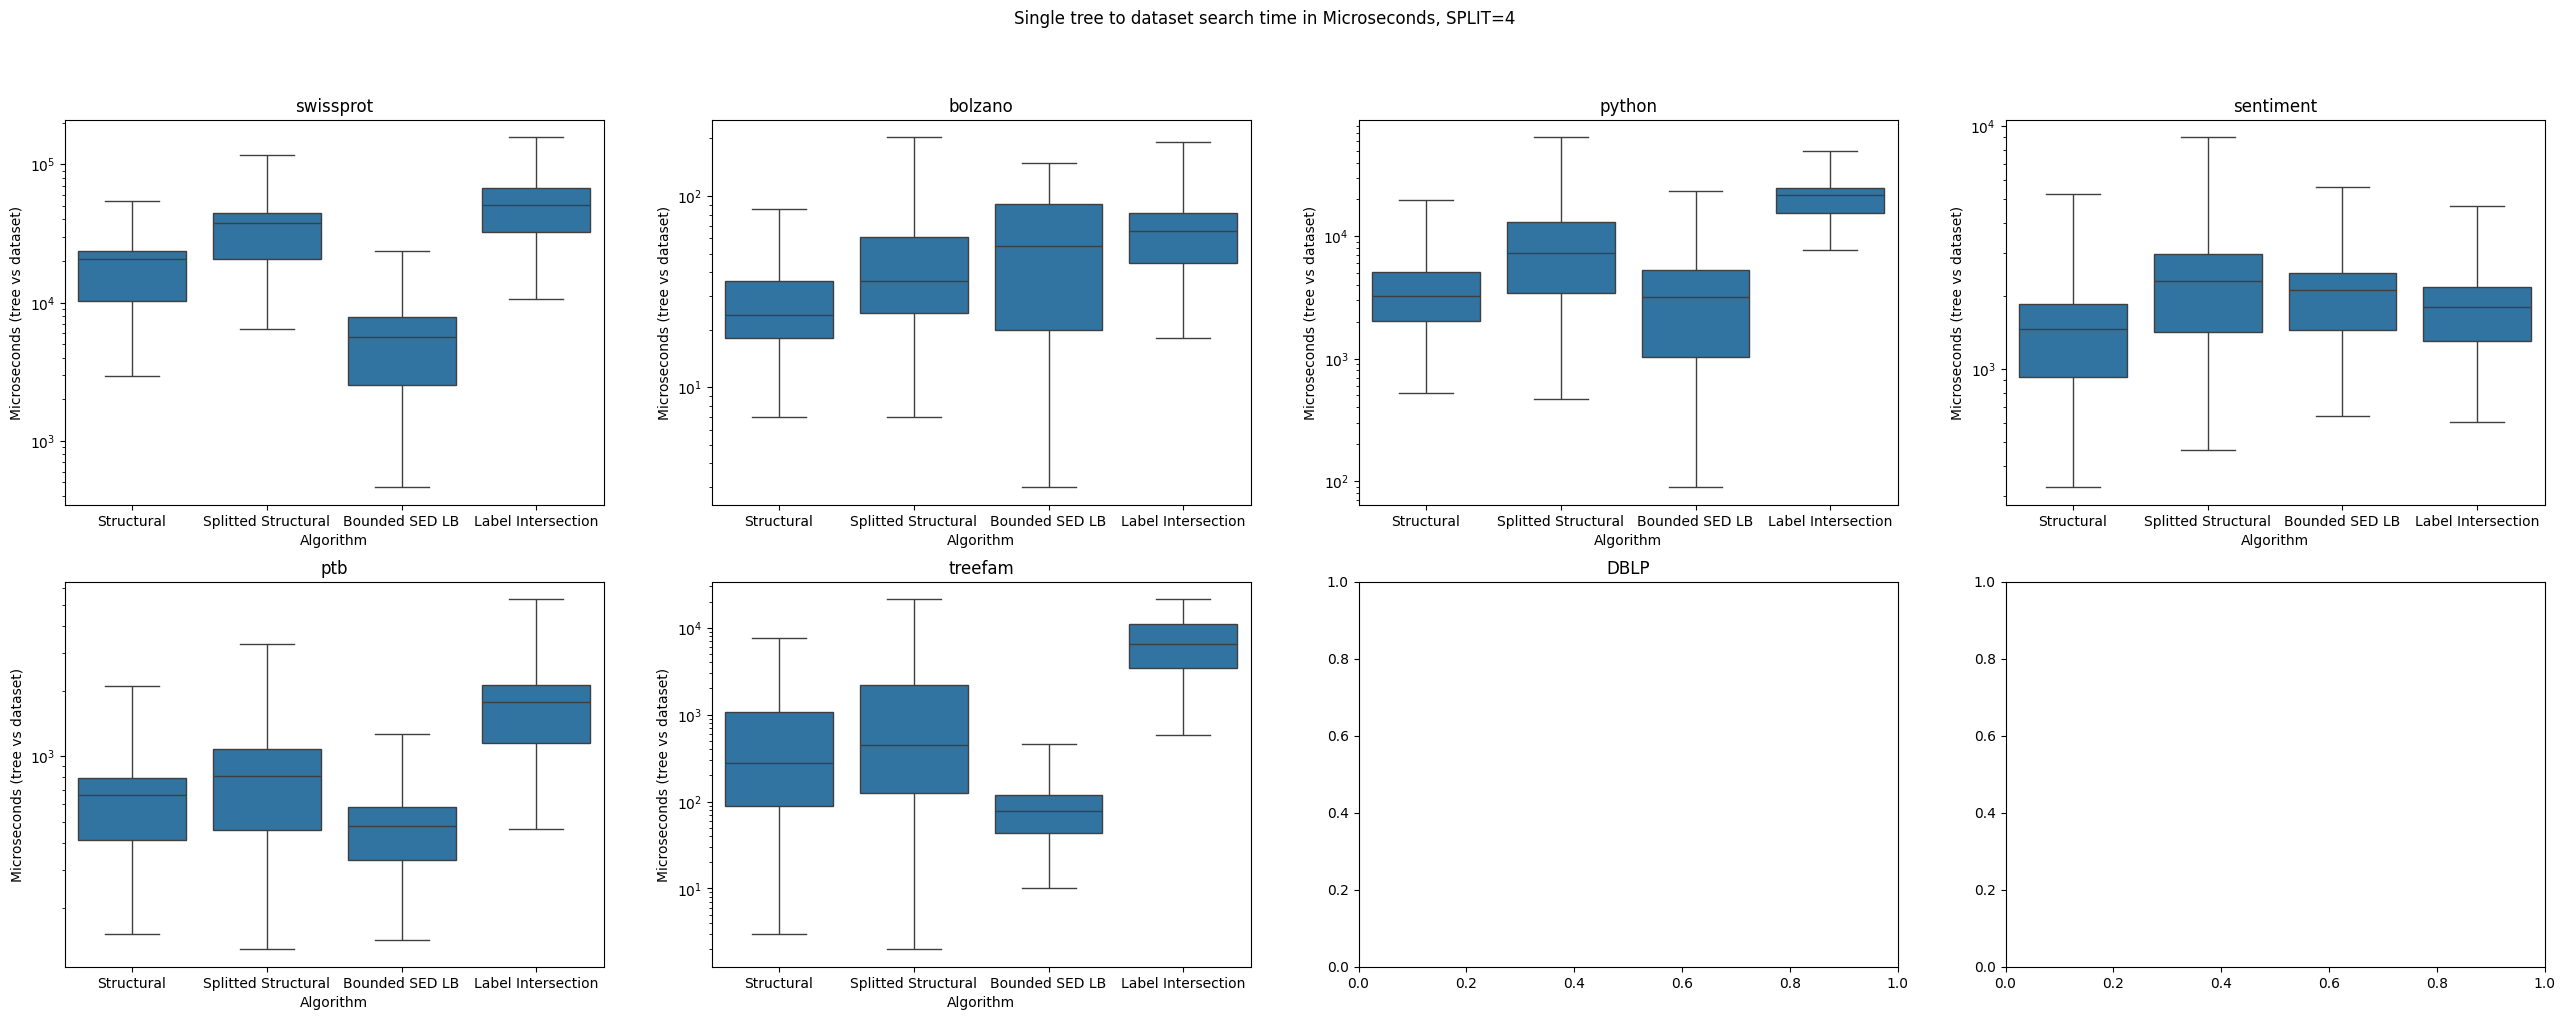

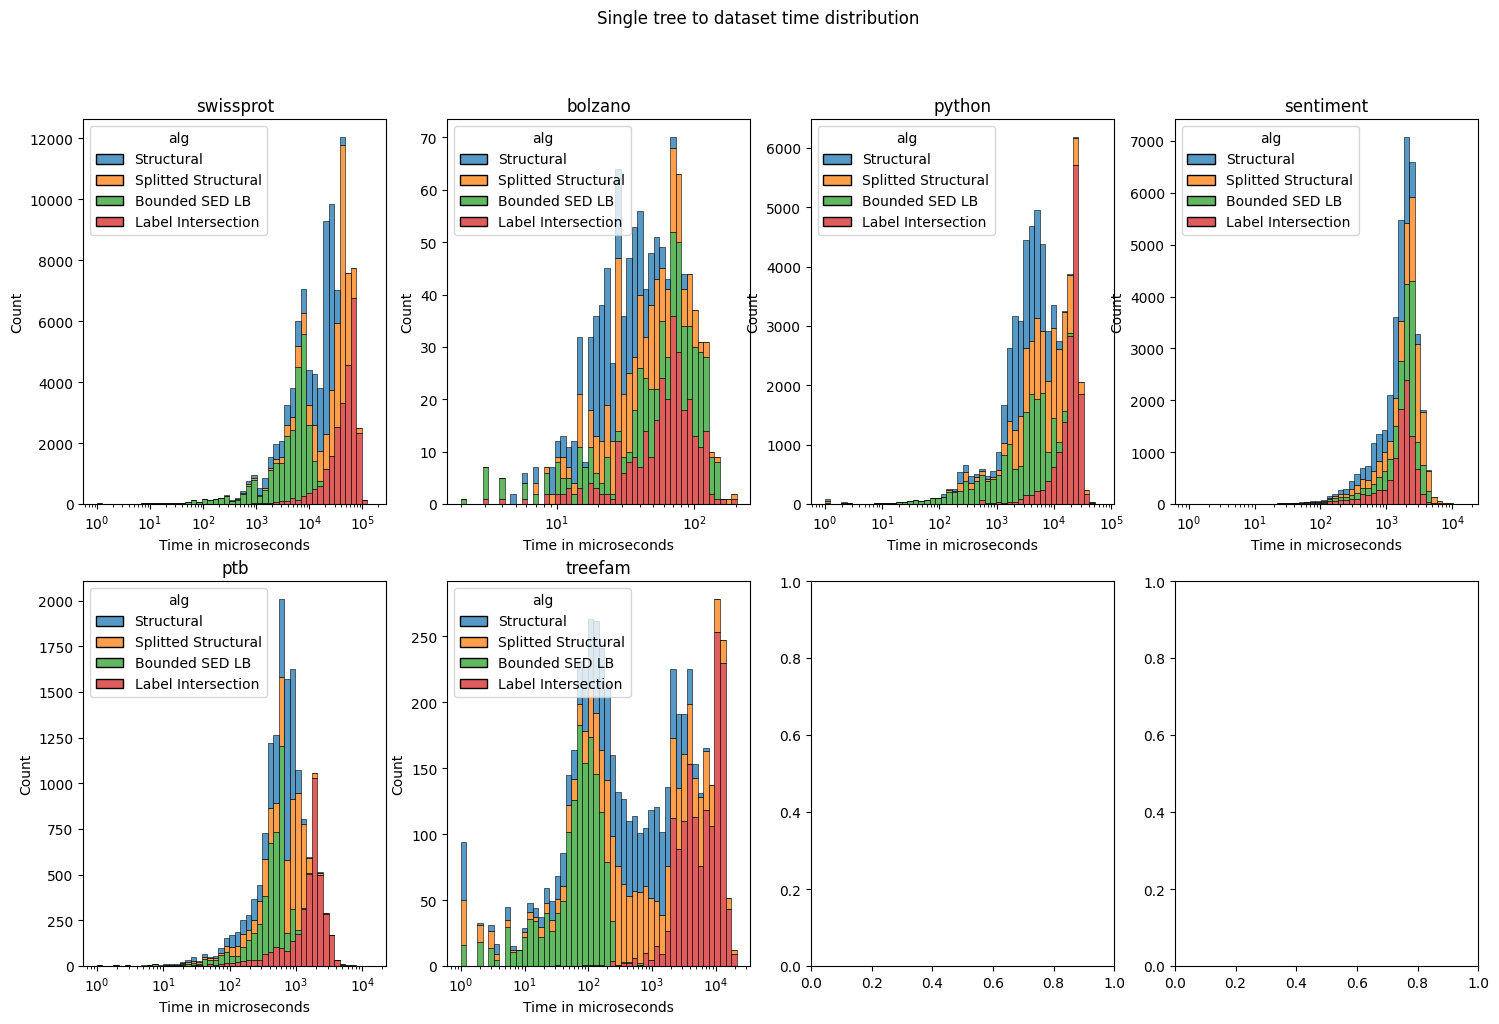

In [26]:
f, axes = plt.subplots(2, 4, figsize=(32, 11))
f.suptitle('Single tree to dataset search time in Microseconds, SPLIT=4')
f2, axes2 = plt.subplots(2, 4, figsize=(18, 11))
f2.suptitle('Single tree to dataset time distribution')
for i, (ds, x) in enumerate(tested_values):
    ax = int(i >= 4)
    ay = i % 4
    axes[ax][ay].set_title(ds)
    print('Printing ', ds)
    if ds.lower() == 'dblp':
        continue
    
    df = pd.DataFrame()
    for alg in dataframes[ds].keys():
        times = dataframes[ds][alg][0].copy()
        times['alg'] = ALGORITHMS[alg]
        df = pd.concat([df, times])
    bp = sns.boxplot(data=df, x='alg', y='time', log_scale=True, showfliers=False, ax=axes[ax][ay])
    bp.set(xlabel='Algorithm', ylabel='Microseconds (tree vs dataset)')
    hp = sns.histplot(data=df, x="time", hue='alg', log_scale=True, multiple="stack", ax=axes2[ax][ay], bins=50)
    hp.set(xlabel='Time in microseconds', title=ds)

In [56]:
dataframes['bolzano']['structural-variant'][2].fillna(0).get('selectivity')[0]

5.06

,Correct trees,Extra trees,Precision,Algorithm,Dataset
0,311,2,0.99361,Label Intersection,treefam


Algorithm,Bounded SED LB,Label Intersection,Splitted Structural,Structural
Dataset,,,,
bolzano,0.685273,0.513917,0.588025,0.575131
ptb,0.798300,0.504475,0.623727,0.592266
python,0.000985,0.000773,0.000853,0.000846
sentiment,0.562106,0.333437,0.421961,0.380023
swissprot,0.998211,0.000000,0.957118,0.957118
treefam,1.000000,0.993610,1.000000,1.000000


[Text(0.5, 1.0, 'Precision heatmap, SPLIT=4')]

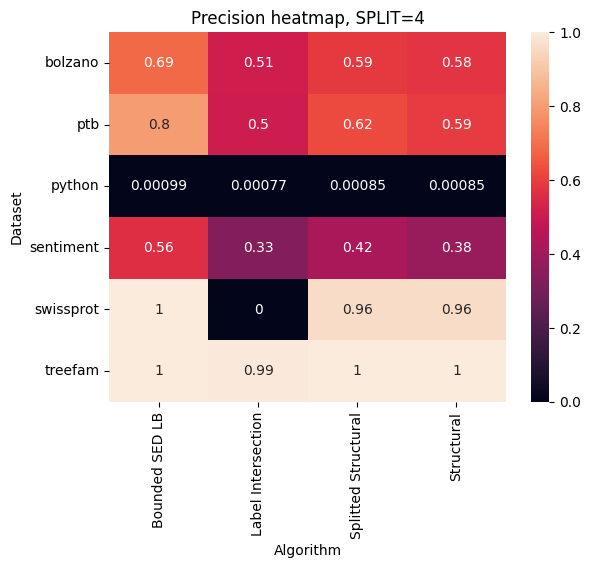

In [61]:
df = pd.DataFrame()

for i, (ds, x) in enumerate(tested_values):
    for alg in dataframes[ds].keys():
        summary = dataframes[ds][alg][1].copy()
        summary['Algorithm'] = ALGORITHMS[alg]
        summary['Dataset'] = ds
        # tpt - time per tree - total time / (number of trees)
        # summary['tpt'] = summary["Total Time"] / (summary["Correct trees"] + summary["Incorrect trees"])
        df = pd.concat([df, summary])
df
display(summary)
pivoted = df.pivot(index="Dataset", columns="Algorithm", values="Precision").fillna(0)
display(pivoted)
hp = sns.heatmap(pivoted, annot=True)
hp.set(title='Precision heatmap, SPLIT=4')

Algorithm,Bounded SED LB,Label Intersection,Splitted Structural,Structural
Dataset,,,,
bolzano,0.042137,0.059676,0.050600,0.051908
ptb,0.000123,0.000195,0.000158,0.000166
python,0.004375,0.005618,0.005070,0.005111
sentiment,0.003421,0.005916,0.004608,0.005141
swissprot,0.000002,0.000002,0.000002,0.000002
treefam,0.000140,0.000140,0.000140,0.000140


[Text(0.5, 1.0, 'Selectivity heatmap, SPLIT=4')]

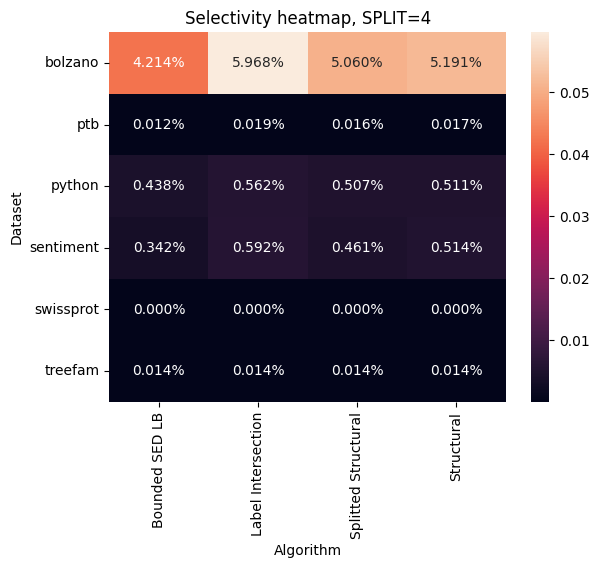

In [76]:
df = pd.DataFrame()

for i, (ds, x) in enumerate(tested_values):
    for alg in dataframes[ds].keys():
        summary = dataframes[ds][alg][1].copy()
        summary['Algorithm'] = ALGORITHMS[alg]
        summary['Dataset'] = ds
        summary['Selectivity'] = dataframes[ds][alg][2].fillna(0).get('selectivity')[0] / 100
        summary = pd.concat([summary, ])
        # tpt - time per tree - total time / (number of trees)
        # summary['tpt'] = summary["Total Time"] / (summary["Correct trees"] + summary["Incorrect trees"])
        df = pd.concat([df, summary])
df
pivoted = df.pivot(index="Dataset", columns="Algorithm", values="Selectivity").fillna(0)
display(pivoted)
hp = sns.heatmap(pivoted, annot=True, fmt='.3%')
hp.set(title='Selectivity heatmap, SPLIT=4')

In [56]:
BASEPATH = 'resources/results/results'
def load_dataset(dataset: str, threshold: int):
    algorithm_times = dict()
    for alg in ALGORITHMS.keys():
        path = join(BASEPATH, dataset, str(threshold), f'{dataset}-{ALGORITHMS_ENUM_NAMES[alg]}-times-us.txt')
        if not exists(path):
            path = join(BASEPATH, ds, f'{dataset}-{ALGORITHMS_ENUM_NAMES[alg]}-times-us.txt')
            # print(alg, 'is not computed for', dataset, f'{path} skipping')

        if not exists(path):
            print(alg, 'is not computed for', dataset, f'{path} skipping')
            continue
        df = pd.read_csv(path, names=["time"])
        precision_path = join(BASEPATH, dataset, str(threshold), f'{dataset}-{alg}-precision.txt')
        if not exists(precision_path):
            precision_path = join(BASEPATH, dataset, f'{dataset}-{alg}-precision.txt')
        
        with open(precision_path) as f:
            selectivity_line = f.readline()
            rest = f.read()

        sel = selectivity_line.split(':')[1]
        sel = float(sel.rstrip('%\n'))
        print(sel)
        seldf = pd.DataFrame.from_dict({'selectivity': [sel] })
        precision = pd.read_csv(StringIO(rest), delimiter=';')
        algorithm_times[alg] = [df, precision, seldf]
    return algorithm_times

In [57]:
dataframes = dict()
tested_values = [('sentiment', 5), ('sentiment', 15), ('sentiment', 20), ('sentiment', 10)]
dataframes['sentiment'] = dict()
for ds, t in tested_values:
    dataframes[ds][t] = load_dataset(ds, t)

0.0326
0.0288
0.0222
0.0393
2.2094
2.0484
1.476
2.674
6.4846
5.9651
4.0985
7.7407
0.5141
0.4608
0.3421
0.5916


,Correct trees,Extra trees,Precision,Algorithm,Threshold
0,173295,346429,0.333437,Label Intersection,10


Threshold,5,10,15,20
Algorithm,,,,
Bounded SED LB,0.755884,0.562106,0.531252,0.714993
Label Intersection,0.429923,0.333437,0.311100,0.421020
Splitted Structural,0.584731,0.421961,0.393487,0.518558
Structural,0.516448,0.380023,0.367358,0.483257


[Text(0.5, 1.0, 'Sentiment Precision heatmap, SPLIT=4')]

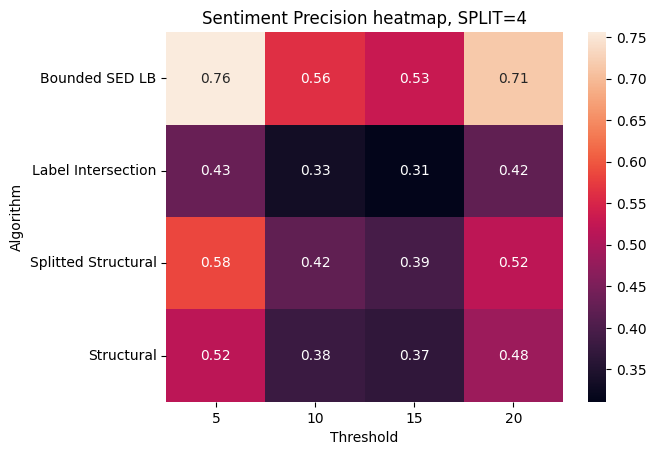

In [59]:
df = pd.DataFrame()

for i, (ds, x) in enumerate(tested_values):
    for alg in dataframes[ds][x].keys():
        summary = dataframes[ds][x][alg][1].copy()
        summary['Algorithm'] = ALGORITHMS[alg]
        summary['Threshold'] = x
        # tpt - time per tree - total time / (number of trees)
        # summary['tpt'] = summary["Total Time"] / (summary["Correct trees"] + summary["Incorrect trees"])
        df = pd.concat([df, summary])
df
display(summary)
pivoted = df.pivot(index="Algorithm", columns="Threshold", values="Precision").fillna(0)
display(pivoted)
hp = sns.heatmap(pivoted, annot=True)
hp.set(title='Sentiment Precision heatmap, SPLIT=4')

In [6]:
selectivities = [('sentiment', 0.0746, 5), ('sentiment', 0.859, 10), ('sentiment', 3.04574, 15), ('sentiment', 8.496, 20)]
pd.DataFrame.from_records(selectivities, columns=['Dataset', 'Mean query selectivity %', 'Threshold'])

,Dataset,Mean query selectivity %,Threshold
0,sentiment,0.07460,5
1,sentiment,0.85900,10
2,sentiment,3.04574,15
3,sentiment,8.49600,20
